In [13]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
with zipfile.ZipFile("nfl-player-contact-detection.zip") as z:
    with z.open("train_labels.csv") as f1:
        df_labels = pd.read_csv(f1)
    with z.open("train_baseline_helmets.csv") as f2:
        df_base_helmet = pd.read_csv(f2)
    with z.open("train_player_tracking.csv") as f3:
        df_player_track = pd.read_csv(f3)
    with z.open("train_video_metadata.csv") as f4:
        df_video_metadata = pd.read_csv(f4)

# BASELINE MODEL Logistic Regression

In [4]:
df_labels.contact.value_counts()

0    4657096
1      64522
Name: contact, dtype: int64

As the target is imbalanced, we will resample it later to have a better estimation of the accuracy (or we can base our result on f1-score)


## Preprocessing
### Treatment of datetime and remove the column not really usefull

In [5]:
df = df_labels.drop(columns=["contact_id", "game_play"])
df.head()

,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,2020-09-11T03:01:48.100Z,0,38590,43854,0
1,2020-09-11T03:01:48.100Z,0,38590,41257,0
2,2020-09-11T03:01:48.100Z,0,38590,41944,0
3,2020-09-11T03:01:48.100Z,0,38590,42386,0
4,2020-09-11T03:01:48.100Z,0,38590,47944,0


In [6]:
df['datetime_column'] = pd.to_datetime(df['datetime'])

In [7]:
df['year'] = df['datetime_column'].dt.year
df['month'] = df['datetime_column'].dt.month
df['day'] = df['datetime_column'].dt.day
df['hour'] = df['datetime_column'].dt.hour
df['minute'] = df['datetime_column'].dt.minute
df['second'] = df['datetime_column'].dt.second

In [8]:
df['second_2'] = df['step'] * 0.1 + df['second']
df.loc[df['second_2'] > 60, 'minute'] += 1

In [9]:
df = df.drop(columns=["datetime", "step","second","datetime_column"])

Replace G by 0 in nfl_player_id_2 (when a player touch the ground

In [10]:
df.loc[df['nfl_player_id_2'] == 'G', 'nfl_player_id_2'] = 0

In [11]:
df.head()

,nfl_player_id_1,nfl_player_id_2,contact,year,month,day,hour,minute,second_2
0,38590,43854,0,2020,9,11,3,1,48.0
1,38590,41257,0,2020,9,11,3,1,48.0
2,38590,41944,0,2020,9,11,3,1,48.0
3,38590,42386,0,2020,9,11,3,1,48.0
4,38590,47944,0,2020,9,11,3,1,48.0


In [14]:
X = df.drop("contact", axis=1)
y = df["contact"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

resamp = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = resamp.fit_resample(X_train, y_train)
X_test, y_test = resamp.fit_resample(X_test, y_test)

baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

In [15]:
cls_rep = classification_report(y_test, y_pred)
print(cls_rep)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy =", accuracy)

MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE =", MSE)

              precision    recall  f1-score   support

           0       0.55      0.92      0.69    931428
           1       0.75      0.26      0.39    931428

    accuracy                           0.59   1862856
   macro avg       0.65      0.59      0.54   1862856
weighted avg       0.65      0.59      0.54   1862856

Accuracy = 0.5870190717908416
MSE = 0.6426359219722769


# BASELINE MODEL Random Forest Classifier 

### This notebook takes into account all the EDA steps taken in `Final_Project_EDA_BASELINE.ipynb`

In [3]:
# video rate (frames per second) given in the task.
FPS = 59.94

I will use `train_labels.csv` and the structure it provides as the basis for building main dataframe for modeling. For the test set provided it should be built from scratch out of other data sources (other .scv files)

At the first stage I also will drop form dataframe `contact_id` and `step` features, presented in `train_labels.csv` data and transform datetime feature in pandas datetime format for more convenient usage.

In [4]:
df = df_labels.copy()
df.drop(['contact_id', 'step'], axis=1, inplace=True)
df.datetime = pd.to_datetime(df.datetime, format='%Y-%m-%dT%H:%M:%S.%fZ')
df.shape

(4721618, 5)

Now I will transform `nfl_player_id_2` to numerical values. To do so firstly I will transform `G` value to zero.

In [5]:
df.loc[df.nfl_player_id_2 == 'G', 'nfl_player_id_2'] = 0
df.nfl_player_id_2 = df.nfl_player_id_2.astype(int)
df.shape

(4721618, 5)

To enrich the data I will use other sources (other `.csv` files) and `pandas.merge()` to add additional information to the dataset. Firstly I will add the video starting timestamp to calculate on what frame game started and to match it with the data from `baseline_helmets.csv` file.

In [6]:
video_timing = df_video_metadata[['game_play','start_time']].copy()
video_timing.start_time = pd.to_datetime(video_timing.start_time, format='%Y-%m-%dT%H:%M:%S.%fZ')
# since there are two videos for every game I will group them and use .min() to find a start time (two video synchronized)
video_timing = video_timing.groupby(by='game_play').min().reset_index()

In [7]:
df = df.merge(video_timing[['game_play', 'start_time']], on='game_play', how='left')
df.shape

(4721618, 6)

In [8]:
# adding number of frame when game starts (step = 0)
df['frame_number'] = (np.array((df.datetime - df.start_time).astype('int64') / 10**9) * FPS).round().astype(int)
df.shape

(4721618, 7)

For every view (`Sideline`, `Endzone`) I will add two columns with unique features (left and top - the position of player's helmet on a frame of video, if he presented on the view). I will add these columns for every player with corresponding suffix (`_p1` or `_p2`).

In [9]:
# adding positions from both videoviews
for video in ['Sideline', 'Endzone']:
    # adding features for both palyers
    for num, player_id in enumerate(['nfl_player_id_1', 'nfl_player_id_2'], start=1):
        df = df.merge(df_base_helmet[['game_play', 'nfl_player_id', 'frame', 'left', 'top']][df_base_helmet.view == video], 
                      left_on=['game_play', 'frame_number', player_id], 
                      right_on=['game_play', 'frame', 'nfl_player_id'],
                      how='left')
        df.rename(columns={'left': f'left_{video.lower()}_p{str(num)}', 
                           'top': f'top_{video.lower()}_p{str(num)}'}, inplace=True)
        df.drop(['nfl_player_id', 'frame'], axis=1, inplace=True)
df.shape

(4721618, 15)

For the **baseline** (simple) model I will fill all the `NaN` values (when player was not presented on a corresponding frame or ground)v with zeros.

In [10]:
df.fillna(0, inplace=True)

Now I add information from personal trackers from `player_tracking.csv` file.

In [11]:
player_track = df_player_track.drop(columns=['game_key', 'play_id', 'step', 'team', 'position']).copy()
player_track.datetime = pd.to_datetime(player_track.datetime, format='%Y-%m-%dT%H:%M:%S.%fZ')

In [12]:
for num, player_id in enumerate(['nfl_player_id_1', 'nfl_player_id_2'], start=1):
    df = df.merge(player_track, 
                  left_on=['game_play', 'datetime', player_id],
                  right_on=['game_play', 'datetime', 'nfl_player_id'],
                  how='left')
    df.rename(columns={'jersey_number': f'jersey_num_p{str(num)}', 
                       'x_position': f'x_p{str(num)}', 
                       'y_position': f'y_p{str(num)}', 
                       'speed': f'speed_p{str(num)}', 
                       'distance': f'distance_p{str(num)}',
                       'direction': f'direction_p{str(num)}', 
                       'orientation': f'orientation_p{str(num)}',
                       'acceleration': f'acceleration_p{str(num)}',
                       'sa': f'sa_p{str(num)}'}, inplace=True)
    df.drop(['nfl_player_id'], axis=1, inplace=True)
df.shape

(4721618, 33)

The same as for `NaN` values after adding information from `baseline_helmets.csv` I will fill new ones with zeros.

In [13]:
df.fillna(0, inplace=True)

Now I am going to keep only relevant columns in the dataframe. To save information (it can be important for the model later on) about type of contact (player with player or player with ground) I will transform data in `nfl_player_id_2` column into binary data where 1 corresponds to `player-player` contact and 0 to `player-ground`.

In [14]:
df.drop(['game_play', 'datetime', 'nfl_player_id_1', 'start_time', 'frame_number'], axis=1, inplace=True)
df.rename(columns={'nfl_player_id_2': 'is_player'}, inplace=True)
df.is_player = (df.is_player > 0).astype(int)
df.shape

(4721618, 28)

Now I want to add some new features that will represent differences (distances) in all kind of coordinates between players.

In [15]:
diff_cols = []
for col in ['left_sideline', 'top_sideline', 'left_endzone', 'top_endzone', 'x', 'y']:
    diff_cols.append(f'{col}_diff')
    df[f'{col}_diff'] = df[f'{col}_p1'] - df[f'{col}_p2']
df.shape

(4721618, 34)

Now I will separate target value and will split data into `train` and `test` sets. Since target variable extremely imbalanced I will stratify my split by it.

In [16]:
X = df.drop('contact', axis=1)
y = df.contact

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=88)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3777294, 33), (3777294,), (944324, 33), (944324,))

As the **baseline** model I will use RandomForestClassifier from `scikit-learn` package with default hyperparameters.

In [17]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

### Results of **baseline** model prediction

In my opinion for this task should be used `recall` as the main metric to evaluate the model performance. Label `1` represents `contact` between players (ground). Recall for prediction label `1` will be considered as the main results of the model.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    931420
           1       0.95      0.73      0.83     12904

    accuracy                           1.00    944324
   macro avg       0.97      0.86      0.91    944324
weighted avg       1.00      1.00      1.00    944324



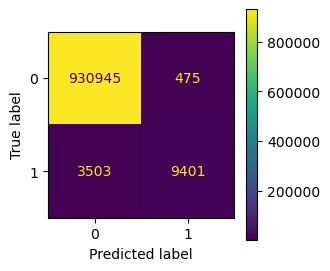

In [18]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(3,3))
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax);

Further some statistics about features importance

In [19]:
importances = rfc.feature_importances_
sort = np.argsort(importances)[::-1]

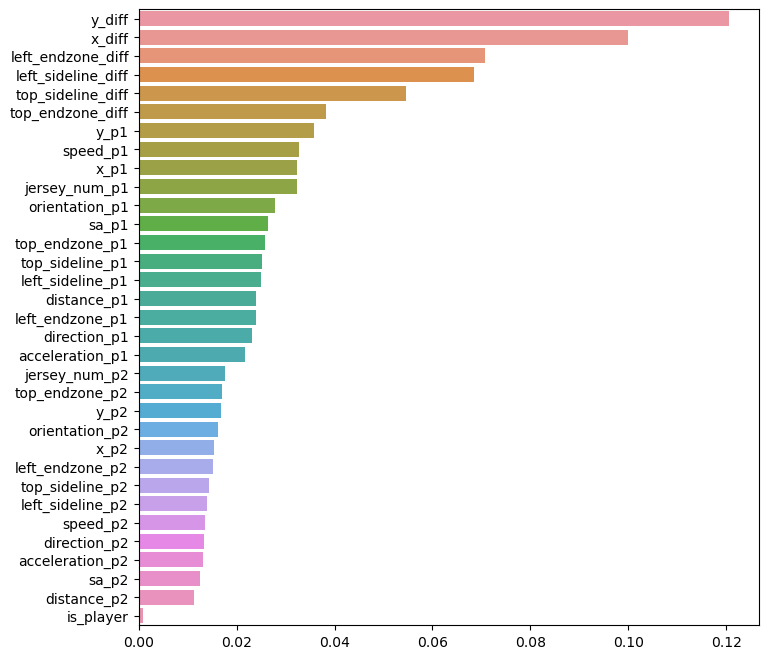

In [20]:
f = plt.figure(figsize=(8,8))
sns.barplot(y=X_train.columns[sort], x=importances[sort])
plt.show()